In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitishpandey04","key":"25e697bcb9f519cb2af5d5a7c19f2874"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 99% 800M/812M [00:06<00:00, 189MB/s]
100% 812M/812M [00:06<00:00, 139MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
import os, shutil, pathlib

In [8]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [9]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
conv_base = keras.applications.vgg16.VGG16(include_top=False, input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [13]:
for images, labels in train_dataset:
    print(images.shape, end=" ")
    print(labels.shape)
    break

(32, 180, 180, 3) (32,)


In [14]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    print(len(all_features), len(all_labels))
    print(all_features[0].shape, all_labels[0].shape)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [15]:
train_features, train_labels = get_features_and_labels(train_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)

63 63
(32, 5, 5, 512) (32,)
63 63
(32, 5, 5, 512) (32,)
32 32
(32, 5, 5, 512) (32,)


In [16]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="feature_extraction_without_DA.keras",
                 save_best_only=True,
                 monitor="val_loss"
             )
]

In [18]:
history = model.fit(train_features, train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 13ms/step - loss: 12.5404 - accuracy: 0.9280 - val_loss: 3.7039 - val_accuracy: 0.9640
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 3.6289 - accuracy: 0.9725 - val_loss: 9.5597 - val_accuracy: 0.9560
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1.9764 - accuracy: 0.9875 - val_loss: 6.9652 - val_accuracy: 0.9680
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.2803 - accuracy: 0.9890 - val_loss: 3.8672 - val_accuracy: 0.9820
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0356 - accuracy: 0.9930 - val_loss: 5.7913 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.4291 - accuracy: 0.9960 - val_loss: 6.5781 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.4565 - accuracy: 0.9935 - val_loss: 4.1100 - val_accuracy: 0.9790
Epoch 8/20
63/63

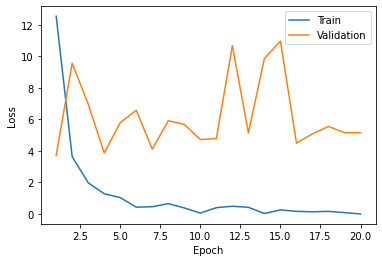

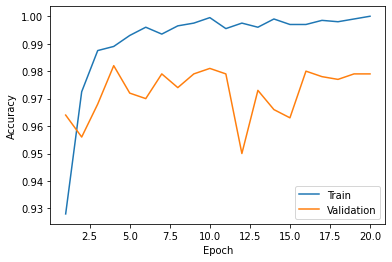

In [19]:
plt.plot(range(1, 21), history.history["loss"], label="Train")
plt.plot(range(1, 21), history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(range(1, 21), history.history["accuracy"], label="Train")
plt.plot(range(1, 21), history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
model.evaluate(test_features, test_labels, batch_size=32)

63/63 [==============================] - 0s 4ms/step - loss: 5.8731 - accuracy: 0.9770


[5.87313985824585, 0.9769999980926514]

### We are able to achieve 97.7% accuracy on test data using transfer learning without data augmentation.